In [1]:
!pip install --upgrade git+https://github.com/kornia/kornia.git
!pip install py7zr

  Cloning https://github.com/kornia/kornia.git to /tmp/pip-req-build-tzsk_ayc
  Running command git clone -q https://github.com/kornia/kornia.git /tmp/pip-req-build-tzsk_ayc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


### Import needed libs and get data to work with

In [2]:
import torch
import kornia
import numpy as np

!wget http://trace.eas.asu.edu/yuv/foreman/foreman_qcif.7z

# prepare the data, decompress so we have a foreman_qcif.yuv ready
import py7zr
with py7zr.SevenZipFile('foreman_qcif.7z', mode='r') as z:
    z.extractall()


--2021-10-09 19:39:23--  http://trace.eas.asu.edu/yuv/foreman/foreman_qcif.7z
Resolving trace.eas.asu.edu (trace.eas.asu.edu)... 149.169.30.44
Connecting to trace.eas.asu.edu (trace.eas.asu.edu)|149.169.30.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6172049 (5.9M) [text/plain]
Saving to: ‘foreman_qcif.7z.4’

foreman_qcif.7z.4   100%[===================>]   5.89M   835KB/s    in 7.7s    

2021-10-09 19:39:31 (788 KB/s) - ‘foreman_qcif.7z.4’ saved [6172049/6172049]



### Define functions for reading the yuv file to torch tensor for use in Kornia

In [3]:
import matplotlib.pyplot as plt

def read_frame(fname, framenum):
  # A typical 420 yuv file is 3 planes Y, u then v with u/v a quartyer the size of Y
  # Build rgb png images from foreman that is 3 plane yuv420
  yuvnp = np.fromfile(fname, dtype=np.uint8, count=int(176*144*1.5), offset=int(176*144*1.5)*framenum)
  y = torch.from_numpy(yuvnp[0:176*144].reshape((1,1,144,176)).astype(np.float32)/255.0)

  uv_tmp = (yuvnp[176*144:int(144*176*3/2)].reshape((1,2, int(144/2),int(176/2))))
  # uv (chroma) is typically defined from -0.5 to 0.5 (or -128 to 128 for 8-bit)
  uv = torch.from_numpy(uv_tmp.astype(np.float32)/255.0)-0.5
  return (y, uv)




### Sample what the images look like Y, u, v channels separaatly and then converted to rgn through kornia (and back to numpy in this case)

as converted through kornia


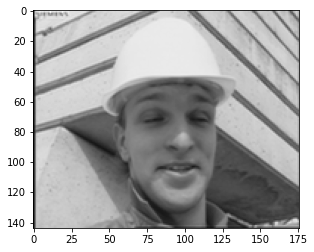

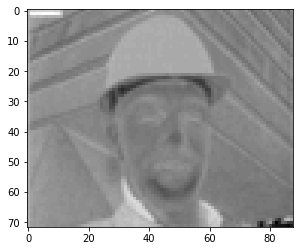

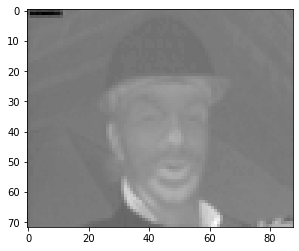

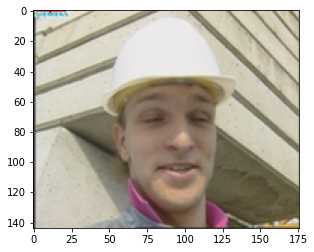

In [4]:
(y, uv) = read_frame("foreman_qcif.yuv", 0) # using compression classic foreman
plt.imshow((y.numpy()[0,0,:,:]*255.0).astype(np.uint8), cmap='gray')
plt.figure()
plt.imshow(((uv.numpy()[0,0,:,:]+0.5)*255.0).astype(np.uint8), cmap='gray')
plt.figure()
plt.imshow(((uv.numpy()[0,1,:,:]+0.5)*255.0).astype(np.uint8), cmap='gray')

rgb = np.moveaxis(kornia.color.yuv420_to_rgb(y,uv).numpy(),1,3).reshape((144,176,3))

print("as converted through kornia")
plt.figure()
plt.imshow((rgb*255).astype(np.uint8))

### We can use these in some internal Kornia algorithm implementations. Lets pretend we want to do LoFTR on the red channel

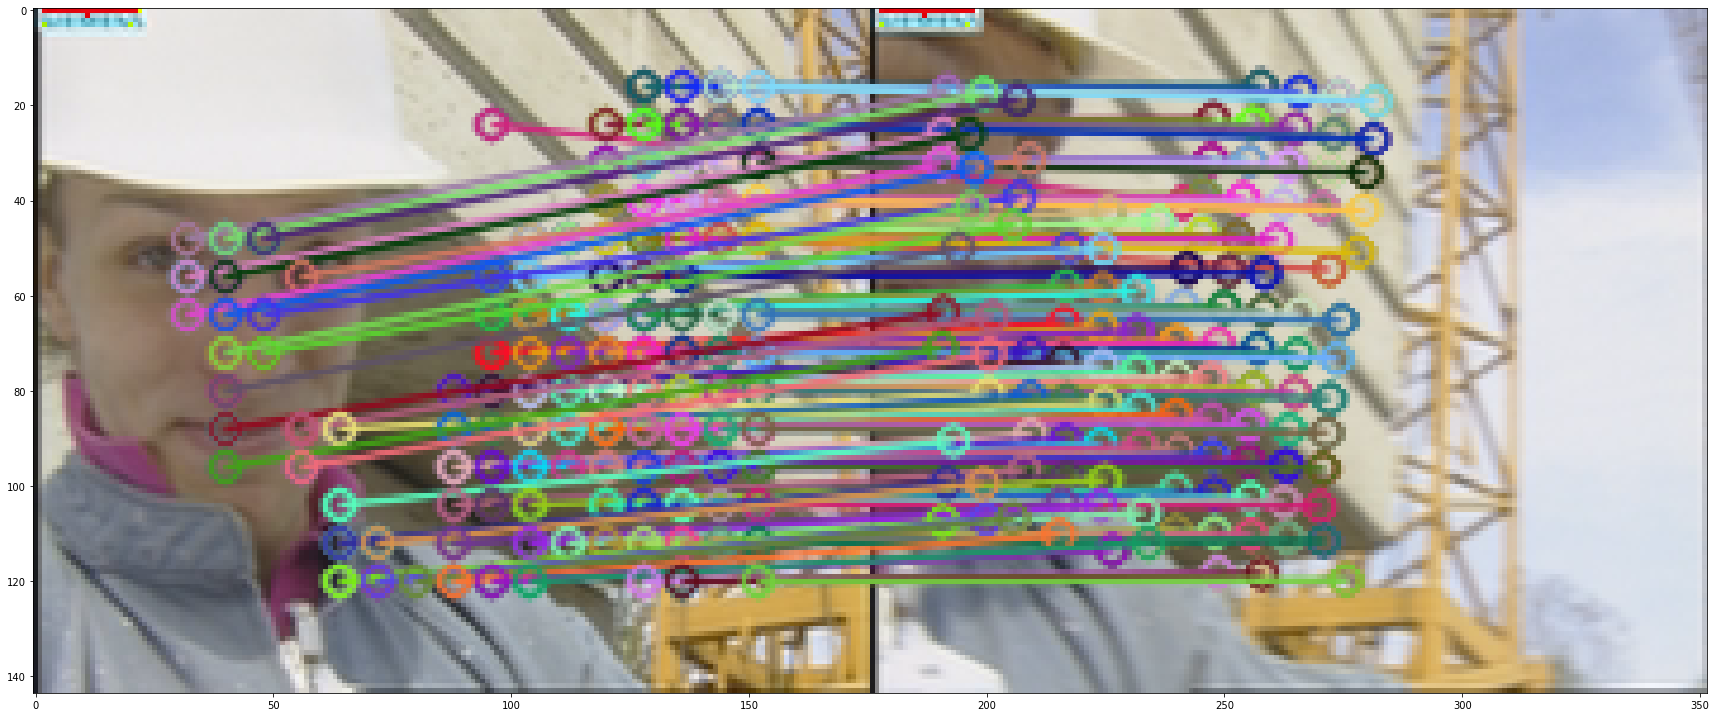

In [35]:
import cv2

loftr = kornia.feature.LoFTR("outdoor")
(y0, uv0) = read_frame("foreman_qcif.yuv", 175)
(y1, uv1) = read_frame("foreman_qcif.yuv", 185)
rgb0 = kornia.color.yuv420_to_rgb(y0, uv0)
rgb1 = kornia.color.yuv420_to_rgb(y1, uv1)

matches = loftr({"image0": rgb0[:,0:1,:,:], "image1": rgb1[:,0:1,:,:]})
matched_image = cv2.drawMatches(np.moveaxis(rgb0.numpy()[0,:,:,:]*255.0, 0, 2).astype(np.uint8),
                                [cv2.KeyPoint(x[0], x[1], 0) for x in matches["keypoints0"].numpy()],
                                np.moveaxis(rgb1.numpy()[0,:,:,:]*255.0, 0, 2).astype(np.uint8),
                                [cv2.KeyPoint(x[0], x[1], 0) for x in matches["keypoints1"].numpy()],
                                [cv2.DMatch(x,x, 0) for x in range(len(matches["keypoints1"].numpy()))], None)

plt.figure(figsize = (30,30))
plt.imshow(matched_image)

